In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import stats
import scipy
%matplotlib inline

!pip install japanize-matplotlib
import japanize_matplotlib #日本語化matplotlib
import seaborn as sns
sns.set(font="IPAexGothic") #日本語フォント設定

     |████████████████████████████████| 4.1MB 3.2MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.2-cp36-none-any.whl size=4120193 sha256=f8362a3a4cd41e9d5eadf65378f5242baeebc000c37726f9b901f9b3ce938842
  Stored in directory: /root/.cache/pip/wheels/9c/f9/fc/bc052ce743a03f94ccc7fda73d1d389ce98216c6ffaaf65afc
Successfully built japanize-matplotlib


/usr/local/lib/python3.6/dist-packages/japanize_matplotlib/japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


### データの読み込み
今回使用しているデータは2019年1月～2020年10月までのラクスの株価データになります。<br>
データ元→https://kabuoji3.com/stock/7974/


In [ ]:
df_2019 = pd.read_csv("drive/My Drive/統計/3923_2019.csv" ,header=1, encoding="shift-jis")
df_2019 = df_2019.drop("終値調整値" , axis=1)
df_2019.head()

,日付,始値,高値,安値,終値,出来高
0,2019-01-04,1662,1719,1643,1710,144200
1,2019-01-07,1787,1830,1758,1812,184700
2,2019-01-08,1812,1850,1790,1805,119100
3,2019-01-09,1824,1825,1761,1784,139000
4,2019-01-10,1788,1791,1727,1741,101900


In [ ]:
df_2020 = pd.read_csv("drive/My Drive/統計/3923_2020.csv" ,header=1, encoding="shift-jis")
df_2020 = df_2020.drop("終値調整値" , axis=1)
df_2020.head()

,日付,始値,高値,安値,終値,出来高
0,2020-01-06,1998,1998,1937,1977,262100
1,2020-01-07,1957,2004,1930,2000,320500
2,2020-01-08,1971,1979,1891,1912,349400
3,2020-01-09,1950,1967,1901,1917,231100
4,2020-01-10,1908,1908,1877,1893,292600


In [ ]:
df = pd.concat([df_2019, df_2020],ignore_index = True)
df.head()

,日付,始値,高値,安値,終値,出来高
0,2019-01-04,1662,1719,1643,1710,144200
1,2019-01-07,1787,1830,1758,1812,184700
2,2019-01-08,1812,1850,1790,1805,119100
3,2019-01-09,1824,1825,1761,1784,139000
4,2019-01-10,1788,1791,1727,1741,101900


In [ ]:
df.describe()

,始値,高値,安値,終値,出来高
count,427.000000,427.000000,427.000000,427.000000,4.270000e+02
mean,2151.871194,2195.475410,2110.405152,2156.943794,3.515967e+05
std,509.673724,518.101877,502.882230,511.378957,2.587060e+05
min,1153.000000,1198.000000,1101.000000,1173.000000,5.650000e+04
25%,1800.500000,1844.000000,1760.500000,1806.000000,1.656500e+05
50%,1970.000000,2015.000000,1941.000000,1988.000000,2.890000e+05
75%,2581.500000,2645.500000,2539.000000,2597.000000,4.447000e+05
max,3730.000000,3745.000000,3600.000000,3670.000000,2.553500e+06


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427 entries, 0 to 426
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   日付      427 non-null    object
 1   始値      427 non-null    int64 
 2   高値      427 non-null    int64 
 3   安値      427 non-null    int64 
 4   終値      427 non-null    int64 
 5   出来高     427 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 20.1+ KB


### 仮説
今回「株価が前日に下落した場合、当日の株価は上がりやすい」という仮説を立て検証していきたいと思います。<br>[
なぜこのような仮説を立てたのかというと、株は安いときに買い、高いときに売るというのが儲かる法則の一つであります。この法則にもとづき前日に株価が下がったときは、当日買いが増え株価が上がり、逆に前日に株価が上がったときは当日売りが増え株価が下がると考えたため、このような仮説を立てました。


### 帰無仮説
今回帰無仮説を、「前日の株価の上昇もしくは下落は当日の株価の増減率に影響を与えない」とします。<br>
もっと砕けた言葉でいうと「前日の株価が上昇したグループと前日の株価が下落したグループの当日の株価増減率の平均は同じである」というのが帰無仮説になります。<br>
有意水準5％で検定していきたいと思います。


### データの生成

In [ ]:
#当日株価が上昇したか下落したかのフラグを作成
#上昇→１、下落→０

df["Rise or fall"] = [ 1 if df["終値"][i] - df["始値"][i] >= 0 else 0  for i in range(len(df))]
df["Rise or fall"]

0      1
1      1
2      0
3      0
4      0
      ..
422    0
423    1
424    0
425    1
426    0
Name: Rise or fall, Length: 427, dtype: int64

In [ ]:
#当日の株価上昇率の算出
#(当日の終値 - 当日の始値）÷　当日の始値

df["rate"] = (df['終値'] - df['始値']) / df['始値']

In [ ]:
#前日に上昇したか下落したかのフラグ
df["before rise or fall"] = df['Rise or fall'].shift(1)

In [ ]:
#Nanがある最初の行を削除
df= df.dropna(axis = 0)

In [ ]:
df.head()

,日付,始値,高値,安値,終値,出来高,Rise or fall,rate,before rise or fall
1,2019-01-07,1787,1830,1758,1812,184700,1,0.013990,1.0
2,2019-01-08,1812,1850,1790,1805,119100,0,-0.003863,1.0
3,2019-01-09,1824,1825,1761,1784,139000,0,-0.021930,0.0
4,2019-01-10,1788,1791,1727,1741,101900,0,-0.026286,0.0
5,2019-01-11,1736,1768,1703,1729,96800,0,-0.004032,0.0


In [ ]:
#前日株価が上昇したグループと、前日株価が下落したグループで分ける
df_rise = df[df["before rise or fall"] == 1]
df_fall = df[df["before rise or fall"] == 0]

In [ ]:
#前日株価が上昇したもの
df_rise.describe()

,始値,高値,安値,終値,出来高,Rise or fall,rate,before rise or fall
count,228.000000,228.000000,228.000000,228.000000,2.280000e+02,228.000000,228.000000,228.0
mean,2200.912281,2244.254386,2159.105263,2201.622807,3.571838e+05,0.478070,0.000141,1.0
std,518.422014,528.951208,513.011689,523.628528,2.946455e+05,0.500618,0.027405,0.0
min,1225.000000,1272.000000,1187.000000,1200.000000,5.650000e+04,0.000000,-0.096970,1.0
25%,1826.250000,1865.750000,1797.750000,1835.750000,1.604500e+05,0.000000,-0.015307,1.0
50%,1998.500000,2033.000000,1973.000000,2000.000000,2.855000e+05,0.000000,-0.001674,1.0
75%,2657.750000,2692.250000,2596.750000,2662.250000,4.136500e+05,1.000000,0.013300,1.0
max,3730.000000,3745.000000,3600.000000,3670.000000,2.553500e+06,1.000000,0.148673,1.0


In [ ]:
#前日株価が下落したもの
df_fall.describe()

,始値,高値,安値,終値,出来高,Rise or fall,rate,before rise or fall
count,198.000000,198.000000,198.000000,198.000000,1.980000e+02,198.000000,198.000000,198.0
mean,2097.873737,2141.712121,2056.686869,2107.752525,3.462106e+05,0.595960,0.005616,0.0
std,495.084487,501.252009,486.668508,493.758870,2.107345e+05,0.491949,0.029218,0.0
min,1153.000000,1198.000000,1101.000000,1173.000000,5.930000e+04,0.000000,-0.066776,0.0
25%,1777.500000,1806.000000,1725.500000,1777.750000,1.827500e+05,0.000000,-0.010264,0.0
50%,1945.500000,1966.000000,1910.000000,1951.000000,2.922000e+05,1.000000,0.003112,0.0
75%,2492.500000,2538.000000,2397.000000,2503.000000,4.623750e+05,1.000000,0.020791,0.0
max,3725.000000,3745.000000,3500.000000,3635.000000,1.218300e+06,1.000000,0.143946,0.0


### ヒストグラムによる可視化


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


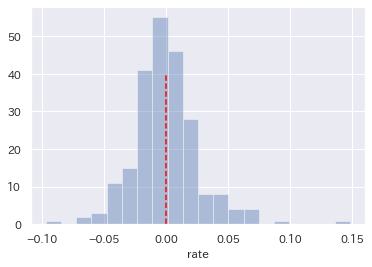

In [ ]:
#前日株価が上昇した、当日の株価rateの分布
sns.distplot(df_rise["rate"], kde=False, rug=False, bins=20) 
plt.vlines([0], 0 , 40, "red", linestyles='dashed')
plt.show()  

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


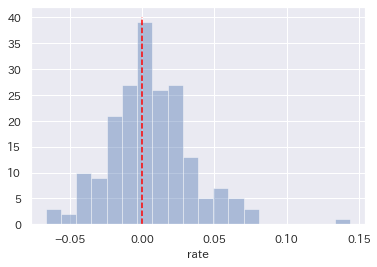

In [ ]:
#前日株価が下落した、当日の株価rateの分布
sns.distplot(df_fall["rate"], kde=False, rug=False, bins=20) 
plt.vlines([0], 0 , 40, "red", linestyles='dashed')
plt.show()  

上の図が、前日に株価が上昇したときの当日の株価の増減率の分布グラフ<br>
下の図が、前日に株価が下落したときの当日の株価の増減率の分布グラフ<br>
今、このヒストグラムを見てみると上の図のほうがrateの低いほうに分布の中心があるようにも思えます。仮にそうであるとするならば、前日の株価の上昇・下落によって当日の株価の値動きも変化が起こるということになります。

### 箱ひげ図による可視化

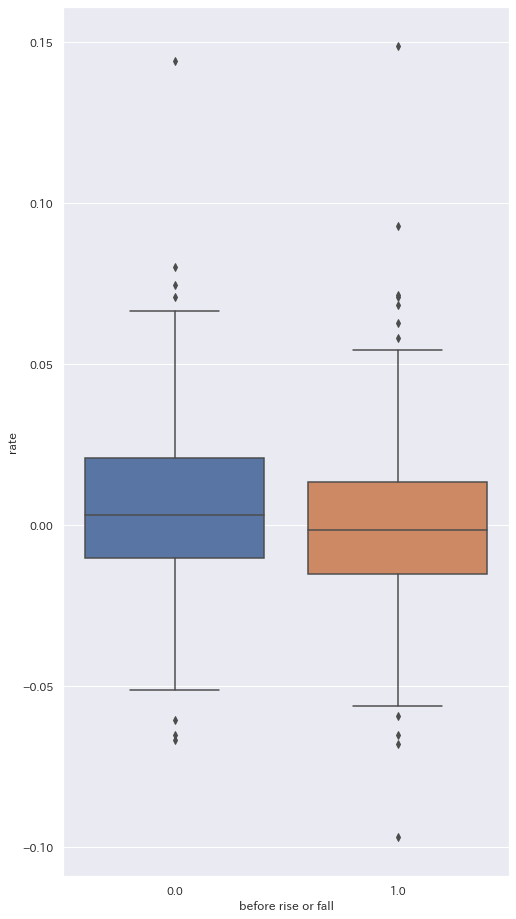

In [ ]:
plt.figure(figsize=(8,16))
sns.boxplot(x='before rise or fall', y='rate', data=df)
plt.show()

今、箱ひげ図でのそれぞれの分布を見てみたが若干前日株価が下がったグループのほうがrateの中央値が上であることが分かります。

### 統計解析
母平均の差を検定する。<br>
まず母分散が分からない場合、母平均が等しいかどうかを検定するには2つのパターンに分けられます。<br>
・ケース１：２つの母分散はわからないが、等しいとみなせる場合<br>
・ケース２：２つの母分散の値が分からず、等しいとも限らない場合<br>
<br>
まず、母分散が等しいかどうかを検定します。

### 母分散が等しいかどうかを調べる。
①帰無仮説:「前日の株価が上昇したグループと前日の株価増減率$σ_r^2$と下落したグループの当日の株価増減率の分散$σ_f^2$は等しい。」とする。$H_0(σ_r^2=σ_f^2)$


In [ ]:
#それぞれの不偏分散を求める
rise_var = np.var(df_rise["rate"].values, ddof=1)# riseの不偏分散
fall_var = np.var(df_fall["rate"].values, ddof=1)# fallの不偏分散
print("前日の株価が上昇したグループの不偏分散：{}".format(rise_var))
print("前日の株価が下落したグループの不偏分散：{}".format(fall_var))

前日の株価が上昇したグループの不偏分散：0.0007510446313052848
前日の株価が下落したグループの不偏分散：0.0008536790740697306


In [ ]:
#統計量Fの算出
F = rise_var / fall_var
print("統計量F:{}".format(F))

統計量F:0.8797739737543779


In [ ]:
rise_m = len(df_rise) - 1  # rise_rateの自由度
fall_n = len(df_fall) - 1  # fall_rateの自由度

rv = stats.f(rise_m,fall_n)
rv.interval(0.95)#95%の信頼区間

(0.763899281203145, 1.312513508173752)

In [ ]:
#片側検定の場合
#有意水準を5%とした場合
#p_value <= 0.05であれば棄却出来る。
pval1 = stats.f.cdf(F, rise_m, fall_n)  # 片側検定のp値・その１
pval2 = stats.f.sf(F, rise_m, fall_n)  # 片側検定のp値・その２
p_value = min(pval1, pval2) * 2  # 両側検定のp値
print(p_value)

0.3506067389305114


今回、検定統計量Fは棄却域に含まれません。またｐ値を算出してみても有意水準5%以下になっていない。そのため帰無仮説である「前日の株価が上昇したグループと前日の株価増減率$σ_r^2$と下落したグループの当日の株価増減率の分散$σ_f^2$は等しい。」は棄却されません。ということは、2つの母分散は等しくないとは言えないことが分かる。<br>


以上の結果から、母分散が等しいと仮定して母平均が等しいかどうかを検定していきます。<br>
ここでは2つの母平均が等しいものと仮定します。<br>
従って、帰無仮説は「前日の株価が上昇したグループの当日の株価増減率の平均$μ_r$と前日の株価が下落したグループの当日の株価増減率の平均$μ_f$は同じである」として考えていきます。($μ_r=μ_f$)

In [ ]:
U_rf = (rise_var * rise_m + fall_var * fall_n) / (rise_m + fall_n)#分散の加重平均

In [ ]:
rise_mean = df_rise["rate"].mean() 
fall_mean = df_fall["rate"].mean() 

T = (rise_mean - fall_mean)/np.sqrt((1/(rise_m + 1) + 1/(fall_n + 1))*U_rf)
T

-1.9940683268497252

この検定統計量Tは自由度（424）のt分布に従う

In [ ]:
rv = stats.t(424)
rv.interval(0.95)#95%の信頼区間

(-1.9655746975220503, 1.9655746975220503)

In [ ]:
#p値を見てみて有意水準を確認してみる。
#p値が0.05以下なので帰無仮説を棄却する
t, p = stats.ttest_ind(df_rise["rate"].values, df_fall["rate"].values, equal_var=True)
print(p)

0.04678459533154817


今回分析をした結果、帰無仮説は有意水準5%で棄却されます。<br>
そのため、「前日の株価が上昇したグループと前日の株価が下落したグループの当日の株価増減率の平均は同じである」という仮説は誤りであり、前日に株価が上昇したか下落したかが当日の株価に影響を与えているということが言えそうである。

In [ ]:
print(rise_mean)
print(fall_mean)

0.00014132622828234438
0.005615833840312505


また、2つのグループの増減率の平均を比べてみると、前日下落時の当日株価増減率が前日上昇時の当日株価増減率に比べて高くなっているので、ラクスの株価は前日に株価が下落していれば当日の株価は比較的上がる傾向にある。

### まとめ
今回、ラクスの株価データを用いて前日に株価が上がったか下がったかどうかで当日の株価に影響があるかについて分析を行ってみました。<br>
結果としてラクスの場合は、前日に株価が下がったのなら当日は株価が上がりやすいという傾向がみられた。<br>

